In [227]:
import os
from pathlib import Path
from typing import Dict, Any, List

import numpy as np
import random
import matplotlib.pyplot as plt

from collections import OrderedDict, defaultdict

import json
import pickle
import itertools
import pprint

In [3]:
# globals

cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Sequential-my'] = [
            'YlOrBr', 'Blues', 'Reds', 'Greens', 'Oranges', 'Purples', 'PuRd', 'GnBu', 'BuGn']


In [46]:
home = Path.home()

logs_struct_path = 'Documents/02-MasterThesis/logs_n_plots/logs_struct'
rq_dirs = ['0', '11-RQ1', '12-RQ2', '13-RQ3', '14-RQ4', '15-RQ5']

txt_files = ['logs_to_plot.txt', 'logs_to_plot1.txt', 'logs_to_plot2.txt',  'logs_to_plot3.txt']
json_files = ['logs_to_plot.json', 'logs_to_plot1.json', 'logs_to_plot2.json',  'logs_to_plot3.json']

# define path to final logs
res_path = Path('./final_logs/')
file_name = "metrics.json"
metrics_include = {}

metrics_include['train'] = ['loss',]
metrics_include['val'] = ['AUC']


In [7]:
def create_plot_labels():
    pass

def select_relevant_exps():
    pass

def plot_simple_run(data, labels, fig_size=(10,5)):

    n_points = 100

    if data == None:
        data_points = {}
        data_points['bce-loss/train'] = np.random.rand(n_points) * 2
        data_points['bce-loss/test'] = np.random.rand(n_points) * 2

        #data_points['bce-log-loss/train'] = np.random.rand(n_points) * 2
        #data_points['bce-log-loss/test'] = np.random.rand(n_points) * 2

    fig, ax = plt.subplots(figsize=fig_size)
    plt.style.use('seaborn')

    #color = iter(plt.cm.rainbow(np.linspace(0, 1, len(data_points))))
    #c = next(color)
    c = 'blue'
    for key, vals in data_points.items():
        if key.__contains__('test'):
            ls = '--'
        else:
            ls = '-'
        ax.plot(vals, label=key, linestyle=ls)

    ax.set_xlabel('Epoch')  # Add an x-label to the axes.
    ax.set_ylabel('y label')  # Add a y-label to the axes.
    ax.set_title("Simple Plot")  # Add a title to the axes.
    ax.legend()  # Add a legend.

    plt.show()

def plot_mul_runs_subplots(exp_data, exp_labels : [str], metric_first_plot : [str], xlabel, save_title : str,
                           n_vals=300, sub_plots=(1, 2), fig_size=(11, 7), incl_metric_key=False, train_dashed=True, show_title=None):

    '''
    input: list of dicts
    each list entry (experiment) contains losses (train + test) and metrics (4)
    corresponding metrics have same color but test is dashed

    data format: list(dict) [exp1, exp2, ... ]
    e.g.:
        exp1:
        {   metric1 : [vals],
            metric2 : [vals],
            ... }

    - From list of Sequential Colormaps Select n_experiments cmaps
    - each cmap n_metrics colors

    :return:
    '''

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=fig_size) # figsize=fig_size, fig.tight_layout()

    if show_title is not None:
        fig.suptitle(show_title, fontsize=16)

    n_exps = len(exp_data)
    #seq_cmaps = random.sample(cmaps['Sequential'], n_exps)
    seq_cmaps = cmaps['Sequential-my'][:n_exps]
    for i, exp in enumerate(exp_data):
        #select color map
        n_metrics = len(exp.keys())
        cmap = plt.get_cmap(seq_cmaps[i])
        if n_metrics > 2:

            #create colors for each metric
            #colors = iter(random.sample(list(cmap(np.linspace(0.5, 0.9, n_metrics))), n_metrics))
            colors = iter(list(cmap(np.linspace(0.5, 0.9, n_metrics))))
        else:
            colors = iter(list(cmap(np.linspace(0.5, 0.9, 1)))*n_metrics)

        for key, vals in exp.items():
            c = next(colors)

            if incl_metric_key:
                lbl = ' '.join([exp_labels[i], key])
            else:
                lbl = exp_labels[i]

            if key.__contains__('train'):
                ls = '--'
            else:
                ls = '-'

            if key in metric_first_plot:
                axs[0].plot(vals[:n_vals], label=lbl, color=c, linestyle=ls)
            else:
                axs[1].plot(vals[:n_vals], label=lbl, color=c, linestyle=ls)


            # if key.__contains__('train'):
            #     ax.plot(vals[:n_vals], label=lbl, color=c, linestyle='--')
            # else:
            #     ax.plot(vals[:n_vals], label=lbl, color=c, linestyle='-')
            #ax.plot(test_vals, label=lbl + '/test', color=c, linestyle='--')

    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train Loss')
    axs[0].legend()

    #fig.tight_layout()

    axs[1].set_title('Validation AUC')
    axs[1].set_xlabel(xlabel)
    axs[1].legend(loc='lower right')

    if show_title is not None:
        #fig.tight_layout()
        fig.subplots_adjust(top=0.80)

    plt.show()

    fname = "../../plots/" + save_title + ".png"
    fig.savefig(fname, dpi=400, bbox_inches='tight')


def average_metrics_over_runs(result_metrics, add_var=False):
    # aggregate metrics over multiple runs
    #loss, acc, auc, ap
    agg_metrics = zip(*[run.values() for run in result_metrics]) #
    agg_metrics = dict(zip(list(result_metrics[0].keys()), agg_metrics)) # create dict from zip(keys, vals)

    # compute mean for each position
    for key, m_vals in agg_metrics.items():
        train, test = zip(*m_vals)
        # zipped list where each entry concats values at the same position
        # [ (train1[0], train2[0], train3[0]), (train1[1], train2[1], train3[1]), ... ]

        # zip and average / apply function  +  assign back to avg_results
        agg_metrics[key] = (zip_and_apply(train, np.mean),
                            zip_and_apply(test, np.mean))

        if add_var:
            agg_metrics[key + '-var'] = (zip_and_apply(train, np.var),
                                        zip_and_apply(test, np.var))

    return agg_metrics

def zip_and_apply(iterable, fnc):
    #values = list(zip(*values))
    #values = list(map(np.mean, values))
    return list(map(fnc, list(zip(*iterable))))


def loss_metric_subplots(rel_metrics: Dict[str, List[Any]], metrics_include: Dict[str, List[str]],
                         labels: List[str], title: str, ):
    first_plot = ['loss']

def metrics_subplots(rel_metrics: Dict[str, List[Any]], metrics_include: Dict[str, List[str]],
                     labels: List[str], first_plot: List[Any], title: str):
    pass

In [264]:
def load_exps_results(exps, metrics_include):
    rel_metrics = defaultdict(list)
    rel_test_metrics = defaultdict(list)

    # load + aggregate multiple runs 
    for ex in exps:

        ex = ex.strip()
        with open(res_path.joinpath(ex, file_name)) as fin:
            metrics = json.load(fin)

        # { run1: {'train': {'loss': [vals], 'AUC': [vals]},
        #       {'val': {'AUC': [vals], 'MRR': [vals]}
        #
        # }

        for k_data in ['train', 'val']:
            for key, vals in metrics[k_data].items():
                if key in metrics_include[k_data] and 'loss' == key:
                    rel_metrics[key].append(vals)
                elif key in metrics_include[k_data]:
                    rel_metrics["_".join([key, k_data])].append(vals)

        if 'test' in metrics:
            for key, vals in metrics['test'].items():
                rel_test_metrics["_".join([key, 'test'])].append(vals)
                    
    return rel_metrics, rel_test_metrics 

def aggr_mul_runs(logs, metrics_include):

    plot_metrics = defaultdict(dict)
    test_metrics = defaultdict(dict)

    for k_config, exps in logs.items():

        # load + aggregate multiple runs 
        plot, test = load_exps_results(exps, metrics_include)
        
        
        # average metrics
        plot_metrics[k_config] = average_metrics(plot)
        test_metrics[k_config] = average_metrics(test)
        
    return plot_metrics, test_metrics
    
    
def pad_list(l, l_max, pad_val=None):
    if len(l) < l_max:
        return l + [pad_val] * (l_max - len(l))
    
    else:
        return l
    
def average_metrics(metrics):
    
    avg_metrics = defaultdict(list)
    
    for k_metric, vals in metrics.items():
        # check length of entries
        l = [len(v) if isinstance(v, list) else 1 for v in vals]

        # pad shorter ones with Nan
        if len(set(l)) != 1:
            vals = [pad_list(v, np.max(l), pad_val=np.nan) for v in vals]       
        
        if any(leng > 1 for leng in l):
            # zip n average
            avg = [np.nanmean(x) for x in zip(*vals)]    
            std = [np.nanstd(x) for x in zip(*vals)]

        else:
            #print("test")
            avg = np.nanmean(vals)
            std = np.nanstd(vals)


        avg_metrics[k_metric] = [avg, std]
        
    return avg_metrics

In [242]:
def plot_mul_runs_subplots(exp_data, exp_labels : [str], metric_first_plot : [str], xlabel, save_title : str,
                           n_vals=300, sub_plots=(1, 2), fig_size=(11, 7), incl_metric_key=False, train_dashed=True, 
                           show_title=None, y_lim=None):

    '''
    input: list of dicts
    each list entry (experiment) contains losses (train + test) and metrics (4)
    corresponding metrics have same color but test is dashed

    data format: list(dict) [exp1, exp2, ... ]
    e.g.:
        exp1:
        {   metric1 : [vals],
            metric2 : [vals],
            ... }

    - From list of Sequential Colormaps Select n_experiments cmaps
    - each cmap n_metrics colors

    :return:
    '''

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=fig_size) # figsize=fig_size, fig.tight_layout()

    if show_title is not None:
        fig.suptitle(show_title, fontsize=16)

    n_exps = len(exp_data)
    #seq_cmaps = random.sample(cmaps['Sequential'], n_exps)
    seq_cmaps = cmaps['Sequential-my'][:n_exps]
    for i, (exp, metrics) in enumerate(exp_data.items()):
        #select color map
        n_metrics = len(metrics)
        cmap = plt.get_cmap(seq_cmaps[i])
        if n_metrics > 2:

            #create colors for each metric
            #colors = iter(random.sample(list(cmap(np.linspace(0.5, 0.9, n_metrics))), n_metrics))
            colors = iter(list(cmap(np.linspace(0.5, 0.9, n_metrics))))
        else:
            colors = iter(list(cmap(np.linspace(0.5, 0.9, 1)))*n_metrics)

        for key, vals in metrics.items():
            c = next(colors)

            if incl_metric_key:
                lbl = ' '.join([exp_labels[i], key])
            else:
                lbl = exp_labels[i]

            if key.__contains__('train'):
                ls = '--'
            else:
                ls = '-'

            if key in metric_first_plot:
                axs[0].plot(vals[0][:n_vals], label=lbl, color=c, linestyle=ls)
            else:
                axs[1].plot(vals[0][:n_vals], label=lbl, color=c, linestyle=ls)


            # if key.__contains__('train'):
            #     ax.plot(vals[:n_vals], label=lbl, color=c, linestyle='--')
            # else:
            #     ax.plot(vals[:n_vals], label=lbl, color=c, linestyle='-')
            #ax.plot(test_vals, label=lbl + '/test', color=c, linestyle='--')
    
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train Loss')
    axs[0].legend()

    axs[1].set_title('Validation AUC')
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel('AUC score')
    axs[1].legend(loc='lower right')
    
    if y_lim is not None:
        for ax, lim in y_lim.items():
            axs[int(ax)].set_ylim(lim)

    if show_title is not None:
        fig.tight_layout()
        fig.subplots_adjust(top=0.90)

    plt.show()

    fname = "./plots/" + save_title + ".png"
    fig.savefig(fname, dpi=400, bbox_inches='tight')

In [243]:
def pprint_test(test):
    for i, (k_config, metrics) in enumerate(test.items()):
        print("\nConfig {}: {}".format(i, k_config))
        for k_m, (val, std) in metrics.items():
            print("\t {}: {:.4f} +/- {:.4f}".format(k_m, val, std))

## RQ4: LTE vs. None

## RQ5: NTE vs. LPE vs. None

In [265]:
# compose metric path
exp_plot_file = home.joinpath(*[logs_struct_path, rq_dirs[5], json_files[1]])

# read in json
with open(exp_plot_file, 'r') as fin: 
    rq_data = json.load(fin)

print(rq_data['info'])
print(rq_data['title'])

RQ5 on dataset l_min=6
xx


In [266]:
logs = rq_data['logs']

metrics_include['train'] = ['loss',]
metrics_include['val'] = ['AUC']

# aggregate_exp_results
plot_metrics, test_metrics = aggr_mul_runs(logs, metrics_include)

In [267]:
plot_metrics.keys()

dict_keys(['None', 'add_lpe', 'add_nte', 'cat_nte', 'add_nte_shuffle', 'cat_nte_shuffle'])

In [268]:
l

[100, 200, 200]

In [269]:
# load + aggregate multiple runs 
plot, test = load_exps_results(logs['add_lpe'], metrics_include)
l = list(map(len, plot['loss']))

{100, 200}

In [253]:
len(plot_metrics['add_lpe']['loss'][0])

100

In [209]:
plot_metrics['None'].items()

2

In [192]:
test_metrics.keys()

dict_keys(['None', 'add_lpe', 'add_nte', 'cat_nte', 'add_nte_shuffle', 'cat_nte_shuffle'])

In [193]:
test_metrics['add_nte']

defaultdict(list,
            {'Recall@5_test': [1.0, 0.0],
             'NDCG@5_test': [0.6725186722040682, 0.006239977809818304],
             'AUC_test': [0.6336916135881104, 0.010620446576476383],
             'MRR_test': [0.5646491448717259, 0.00812545303534352]})

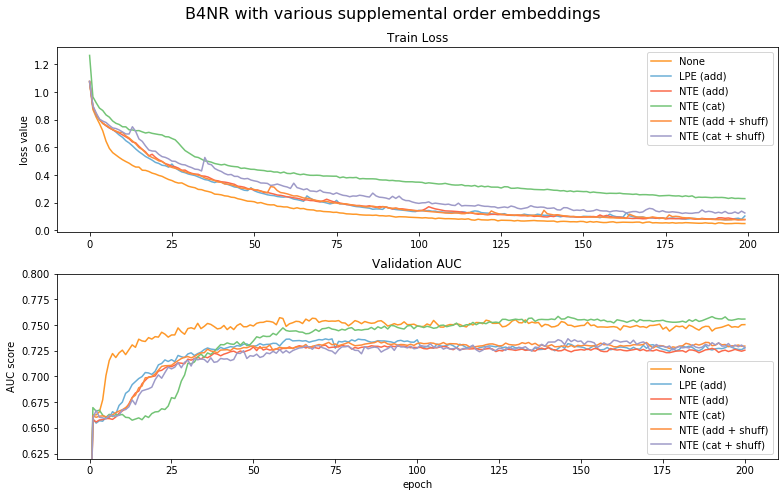

In [270]:
result_labels = ['None', 'LPE (add)', 'NTE (add)', 'NTE (cat)', 'NTE (add + shuff)', 'NTE (cat + shuff)']
title = 'B4NR with various supplemental order embeddings'

plot_mul_runs_subplots(exp_data=plot_metrics, exp_labels=result_labels,
                             metric_first_plot=['loss', 'AUC_train', 'MRR_train'], xlabel='epoch',
                             save_title=("01_" + title).replace(" ", "_"), show_title=title, y_lim={'1': (0.62, 0.8)})

In [271]:
pprint_test(test_metrics)


Config 0: None
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.7033 +/- 0.0000
	 AUC_test: 0.6781 +/- 0.0000
	 MRR_test: 0.6050 +/- 0.0000

Config 1: add_lpe
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.6743 +/- 0.0050
	 AUC_test: 0.6303 +/- 0.0082
	 MRR_test: 0.5672 +/- 0.0065

Config 2: add_nte
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.6725 +/- 0.0062
	 AUC_test: 0.6337 +/- 0.0106
	 MRR_test: 0.5646 +/- 0.0081

Config 3: cat_nte
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.7058 +/- 0.0000
	 AUC_test: 0.6853 +/- 0.0000
	 MRR_test: 0.6082 +/- 0.0000

Config 4: add_nte_shuffle
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.6706 +/- 0.0014
	 AUC_test: 0.6286 +/- 0.0019
	 MRR_test: 0.5622 +/- 0.0019

Config 5: cat_nte_shuffle
	 Recall@5_test: 1.0000 +/- 0.0000
	 NDCG@5_test: 0.6795 +/- 0.0000
	 AUC_test: 0.6387 +/- 0.0000
	 MRR_test: 0.5741 +/- 0.0000


In [136]:
logs['add_nte']

['10k_cnn_add_ntev2_al30_k4_lr1e-3_L2_H4_pD0.2_s1_2020-09-12_0',
 '10k_cnn_add_ntev2_al30_k4_lr1e-3_L2_H4_pD0.2_s2_2020-09-12_0',
 '10k_cnn_add_ntev2_al30_k4_lr1e-3_L2_H4_pD0.2_s3_2020-09-12_0']

In [173]:

plot_metrics = defaultdict(dict)
test_metrics = defaultdict(dict)


    
rel_metrics = defaultdict(list)
rel_test_metrics = defaultdict(list)

# load + aggregate multiple runs    
k_config='add_nte'

for ex in logs[k_config]:

    ex = ex.strip()
    with open(res_path.joinpath(ex, file_name)) as fin:
        metrics = json.load(fin)

    for k_data in ['train', 'val']:
        for key, vals in metrics[k_data].items():
            if key in metrics_include[k_data] and 'loss' == key:
                rel_metrics[key].append(vals)
            elif key in metrics_include[k_data]:
                rel_metrics["_".join([key, k_data])].append(vals)

    if 'test' in metrics:
        for key, vals in metrics['test'].items():
            rel_test_metrics["_".join([key, 'test'])].append(vals)



In [174]:
len(rel_metrics['loss'])

3

False

In [115]:
# construct averaging function

# pass plot metrics to plotting function

# save plot

# display test metrics + std

# save test metrics